In [34]:
from IPython.display import Image
import numpy as np
from matrices import linPolarizer,plotPoincare
from sympy import symbols
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

np.set_printoptions(precision=2)

# Mueller Calculus for Polarizers with Finite Extinction Ratio

Before we model our pixel array we need to know how to represent our polarization filters via Mueller matrices. This derivation heavily references D.H Goldstein's textbook *Polarized Light*.


Given a linear polarizer with amplitude transmission coefficients for $x$ and $y$ polarized light $p_x, p_y$, the Mueller matrix is given by:

$$
    \mathbf{M} = \frac{1}{2} \begin{bmatrix}
p_x^2 + p_y^2 & p_x^2 - p_y^2 & 0 & 0\\
p_x^2 - p_y^2 & p_x^2 + p_y^2 & 0 & 0\\
0 & 0 & 2p_x p_y & 0\\
0 & 0 & 0 &2p_x p_y
\end{bmatrix}
$$

Assuming unity transmittance along the preferred axis ($p_x = 1$), we have $p_y^2 = \frac{1}{r_e}$. Furthermore we can represent a linear polarizer oriented at arbitrary angle $\theta$ with respect to the x-axis using the standard rotation matrix $\mathbf{R}(\theta)$:

$$
\mathbf{R}(\theta) = \begin{bmatrix}
1 & 0 & 0 & 0\\
0 & \cos(2\theta) & \sin(2\theta) & 0\\
0 & -\sin(2\theta) & \cos(2\theta) & 0\\
0 & 0 & 0 & 1
\end{bmatrix}
$$

Yielding the Mueller matrix for a linear polarizer with extinction ratio $r_e$ rotated to angle $\theta$:

$$
\mathbf{M}(r_e, \theta) = \frac{1}{2r_e} \mathbf{R}(-\theta) \cdot
    \begin{bmatrix}
        r_e + 1 & r_e - 1 & 0 & 0\\
        r_e - 1 & r_e + 1 & 0 & 0\\
        0 & 0 & 2 \sqrt{r_e} & 0\\
        0 & 0 & 0 & 2 \sqrt{r_e}
    \end{bmatrix} \cdot
    \mathbf{R}(\theta)
$$

Corresponding matrices for polarizers that transmit RHCP or LHCP light can be constructed analogously:

$$
\mathbf{M}_{RHCP} = \frac{1}{2r_e}\begin{bmatrix}
        r_e + 1 & 0 & 0 & r_e - 1\\
        0 & 2\sqrt{r_e} & 0 & 0\\
        0 & 0 & 2\sqrt{r_e} & 0\\
        r_e - 1 & 0 & 0 & r_e + 1
    \end{bmatrix}, \mathbf{M}_{LHCP} = \frac{1}{2r_e}\begin{bmatrix}
        r_e + 1 & 0 & 0 & 1 - r_e\\
        0 & 2\sqrt{r_e} & 0 & 0\\
        0 & 0 & 2\sqrt{r_e} & 0\\
        1 - r_e & 0 & 0 & r_e + 1
    \end{bmatrix}
$$

These Matrices are defined as functions in ```matrices.py``` and, unsurprisingly, are critically important for modelling the behavior of this array.

# 4 Pixel Linear Wire Grid Polarizer Array

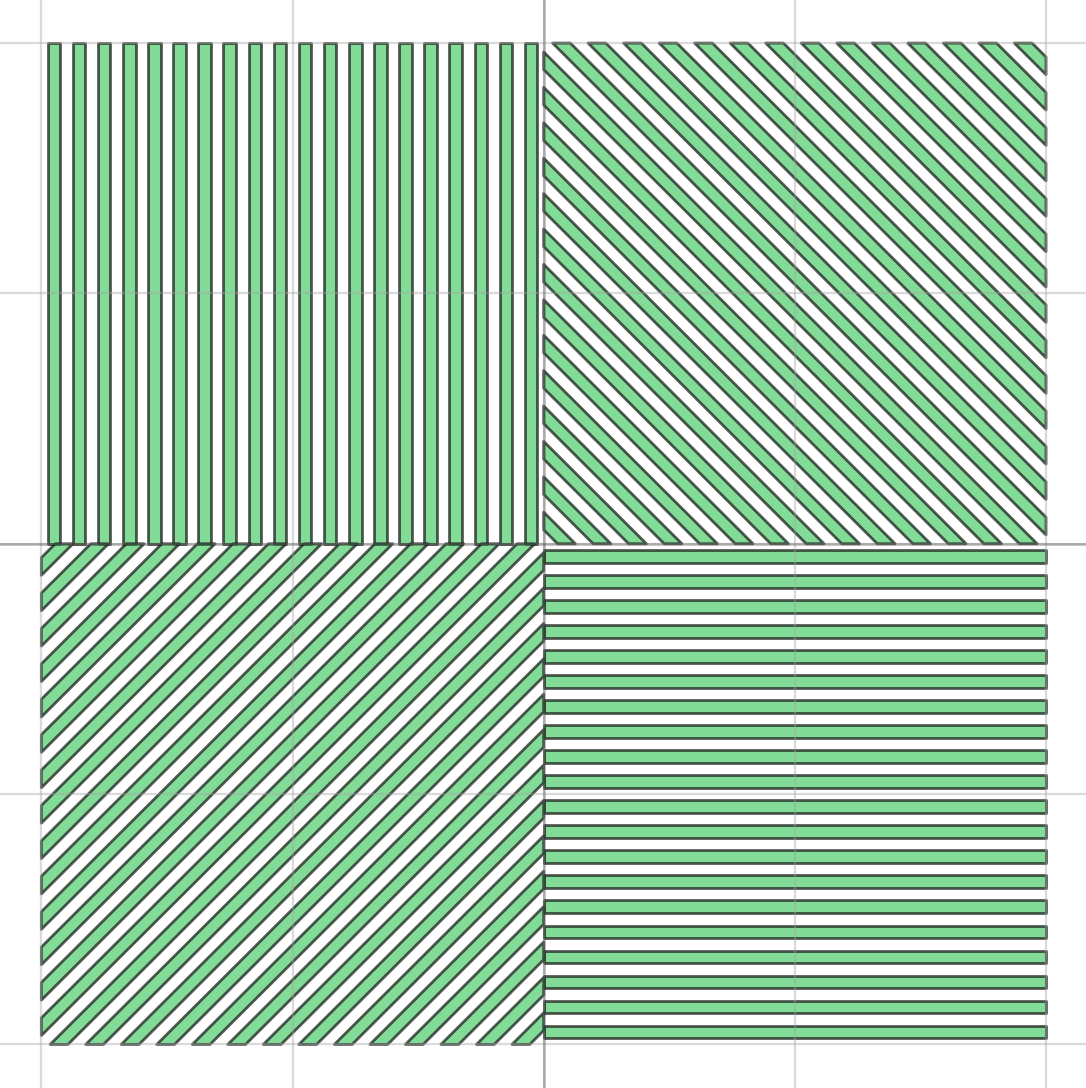

In [35]:
Image(filename="quadArray.png",width=400,height=400)

We want to model the above, 4-Pixel array. We can label our pixels $\left(1,2,3,4\right)$ with corresponding polarization filters oriented to preferentially transmit $\left(0^{\circ}, 45^{\circ}, 90^{\circ}, 135^{\circ}\right)$ linar polarization.

In [36]:
re = 100 #extinction ratio - because we only have linear polarizers, assume constant for all pixels.

m1 = linPolarizer(re,0)
m2 = linPolarizer(re,45)
m3 = linPolarizer(re,90)
m4 = linPolarizer(re,135)

incomingLight = np.array(symbols('a b c d'))

#Stokes vector of light at each pixel
p1 = np.matmul(m1,incomingLight)
p2 = np.matmul(m2,incomingLight)
p3 = np.matmul(m3,incomingLight)
p4 = np.matmul(m4,incomingLight)

#Pixels are only sensitive to intensity
i1 = p1[0]
i2 = p2[0]
i3 = p3[0]
i4 = p4[0]

print(i1)
print(i2)
print(i3)
print(i4)

pixelActivation = np.array((i1,i2,i3,i4))

0.505*a + 0.495*b
0.505*a + 3.0310008278897e-17*b + 0.495*c
0.505*a - 0.495*b + 6.0620016557794e-17*c
0.505*a - 9.0930024836691e-17*b - 0.495*c


What we have here is:

$\vec{P} = \mathbf{M} \cdot \vec{I}$

Where $\vec{P}$ = `pixelActivation`, $\vec{I}$ = `incomingLight`

We can thus extract $\mathbf{M}$:

In [37]:
M = np.zeros((4,4))
for row, x in enumerate(M):
    for column, y in enumerate(x):
        M[row,column] = pixelActivation[row].coeff(incomingLight[column])
print(M)

[[ 5.05e-01  4.95e-01  0.00e+00  0.00e+00]
 [ 5.05e-01  3.03e-17  4.95e-01  0.00e+00]
 [ 5.05e-01 -4.95e-01  6.06e-17  0.00e+00]
 [ 5.05e-01 -9.09e-17 -4.95e-01  0.00e+00]]


If we can construct the left inverse of $\mathbf{M}$, $\mathbf{M}^{-1}$, then we've got a good deal, because:

$\mathbf{M}^{-1} \cdot \vec{P} = \vec{I}$

We can reconstruct $\vec{I}$ given $\vec{P}$!

Note here that we do not have any sensitivity to circular polarization, thus $\mathbf{M}$ is singular and we cannot calculate the full inverse. We can use numpy's `linalg.pinv()` function to calculate the pseudo-inverse, which in this case functions as the left inverse.

In [38]:
Minverse = np.linalg.pinv(M)
print(Minverse)

[[ 4.95e-01  4.95e-01  4.95e-01  4.95e-01]
 [ 1.01e+00 -5.47e-18 -1.01e+00 -4.51e-17]
 [-8.21e-18  1.01e+00 -2.74e-18 -1.01e+00]
 [ 0.00e+00  0.00e+00  0.00e+00  0.00e+00]]


Let's see how this works. Consider various incoming states of polarization:

$$
\begin{align}
    \vec{i1} &= \begin{bmatrix}1\\1\\0\\0\end{bmatrix}, \vec{i2} &= \begin{bmatrix}1\\-1\\0\\0\end{bmatrix},
    \vec{i3} &= \begin{bmatrix}1\\0\\1\\0\end{bmatrix}, \vec{i4} &= \begin{bmatrix}1\\0\\-1\\0\end{bmatrix},
    \vec{i5} &= \begin{bmatrix}1\\0\\0\\1\end{bmatrix}, \vec{i6} &= \begin{bmatrix}1\\0\\0\\-1\end{bmatrix}
\end{align}
$$

$\vec{i1}$ corresponds to Horizontal polarization ($0^{\circ}$), $\vec{i2}$ = vertical ($90^{\circ}$), $\vec{i3} = +45^{\circ}$, $\vec{i4} = -45^{\circ}$, $\vec{i5}$ = RHCP, $\vec{i6}$ = LHCP. We can calculate and visualize the pixel activations that this would yield on our array:

[0.01 0.51 1.   0.51]


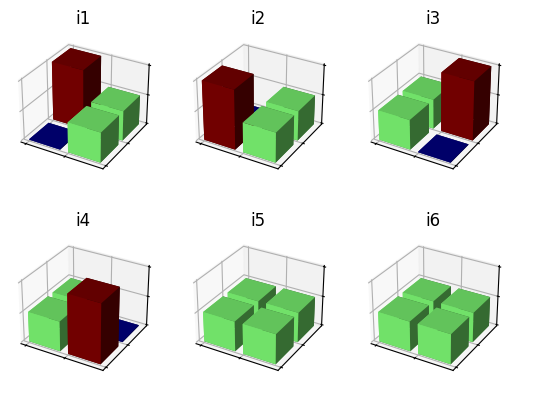

In [43]:
i1 = np.array((1,1,0,0))
i2 = np.array((1,-1,0,0))
i3 = np.array((1,0,1,0))
i4 = np.array((1,0,-1,0))
i5 = np.array((1,0,0,1))
i6 = np.array((1,0,0,-1))

p1 = np.matmul(M,i1)
p2 = np.matmul(M,i2)
p3 = np.matmul(M,i3)
p4 = np.matmul(M,i4)
p5 = np.matmul(M,i5)
p6 = np.matmul(M,i6)

print(p2)

ps = (p1,p2,p3,p4,p5,p6)

fig = plt.figure()

xCoords = (0,1,0,1)
yCoords = (1,1,0,0)
zCoords = (0,0,0,0)
width = 0.8
depth = 0.8
norm = plt.Normalize(0,1)
for i, x in enumerate(ps):
    pltnum = 230 + i + 1
    colors = plt.cm.jet(norm(x))
    ax = fig.add_subplot(pltnum,projection='3d')
    ax.set_title("i%i"%(i+1))
    ax.bar3d(xCoords,yCoords,zCoords,width,depth,x,colors)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])
    ax.set_zlim(0,1)
    #ax.view_init(75, -90)
    

plt.show()


And here we have a nice visualization of how each state of polarization activates each pixel! As we can see for $\vec{i1}, \vec{i2},\vec{i3}$, and $\vec{i4}$ we have clear pixel activation corresponding to a preferred linear state of polarization. The circular polarization states $\vec{i5}$ and $\vec{i6}$ do not preferentially activate a pixel, and as we're about to see that corresponds to a blind spot in the array.

Using $\mathbf{M^{-1}}$ we can use these pixel activation values to reconstruct the original vectors.

In [44]:
r1 = np.matmul(Minverse,p1)
r2 = np.matmul(Minverse,p2)
r3 = np.matmul(Minverse,p3)
r4 = np.matmul(Minverse,p4)
r5 = np.matmul(Minverse,p5)
r6 = np.matmul(Minverse,p6)

print("Reconstructed i1: " + str(r1))
print("Reconstructed i2: " + str(r2))
print("Reconstructed i3: " + str(r3))
print("Reconstructed i4: " + str(r4))
print("Reconstructed i5: " + str(r5))
print("Reconstructed i6: " + str(r6))

Reconstructed i1: [1.00e+00 1.00e+00 1.32e-16 0.00e+00]
Reconstructed i2: [ 1.00e+00 -1.00e+00 -8.73e-17  0.00e+00]
Reconstructed i3: [ 1.00e+00 -9.04e-17  1.00e+00  0.00e+00]
Reconstructed i4: [ 1.00e+00  9.47e-17 -1.00e+00  0.00e+00]
Reconstructed i5: [1.00e+00 2.16e-18 2.22e-17 0.00e+00]
Reconstructed i6: [1.00e+00 2.16e-18 2.22e-17 0.00e+00]


Note that this array can succesfully reconstruct the stokes vectors for states of polarization that do not involve circular polarization, but it is completely insensitive to circular polarization.

Let's visualize how the incoming and reconstructed vectors look on the Poincare sphere:

i1:


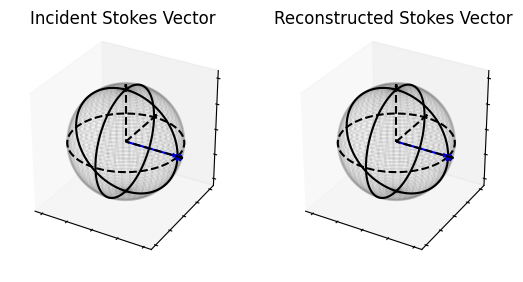

i2:


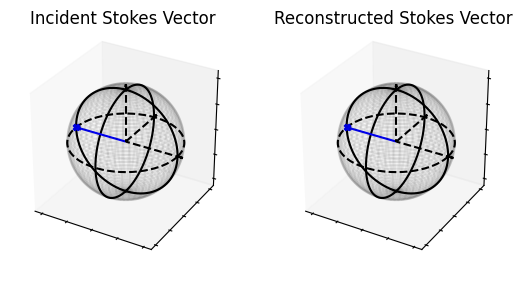

i3:


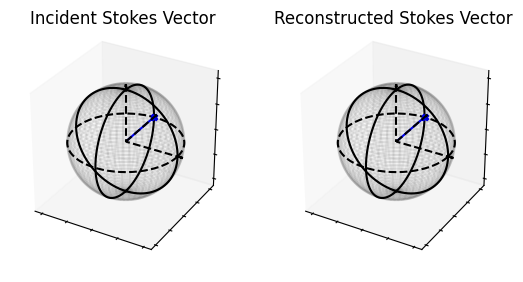

i4:


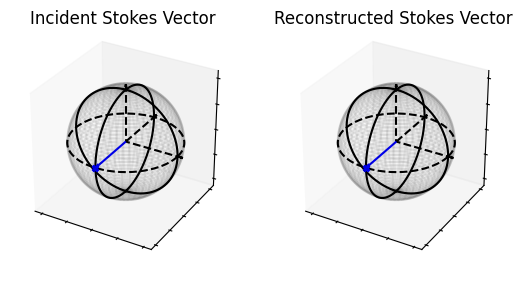

i5:


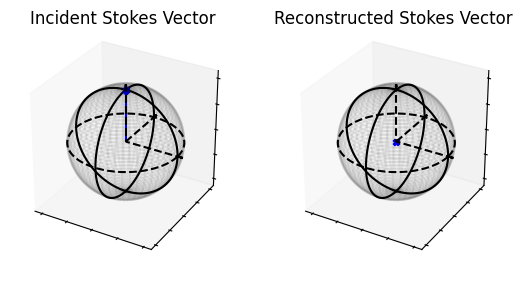

i6:


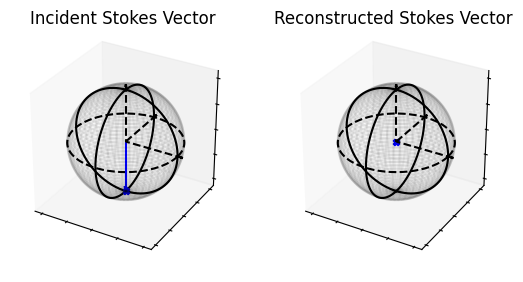

In [45]:
def showReconstruction(s1,s2):
    fig = plt.figure()
    ax1 = fig.add_subplot(121,projection = '3d')
    ax2 = fig.add_subplot(122,projection = '3d')

    #Using function I wrote to visualize poincare sphere, in matrices.py
    ax1 = plotPoincare(s1,ax1)
    ax2 = plotPoincare(s2,ax2)

    ax1.set_title("Incident Stokes Vector")
    ax2.set_title("Reconstructed Stokes Vector")
    plt.show()

print("i1:")
showReconstruction(i1,r1)
print("i2:")
showReconstruction(i2,r2)
print("i3:")
showReconstruction(i3,r3)
print("i4:")
showReconstruction(i4,r4)
print("i5:")
showReconstruction(i5,r5)
print("i6:")
showReconstruction(i6,r6)

Interesting! So the blind spot to circularly polariation essentially means that the vertical component of the Poincare sphere representation gets removed. To see this more clearly let's look at another $i$ with more components:

$$
\vec{i'} = \begin{bmatrix}
2\\-1\\0\\1
\end{bmatrix}
$$

[0.52 1.01 1.5  1.01]
[ 2.00e+00 -1.00e+00  4.71e-17  0.00e+00]


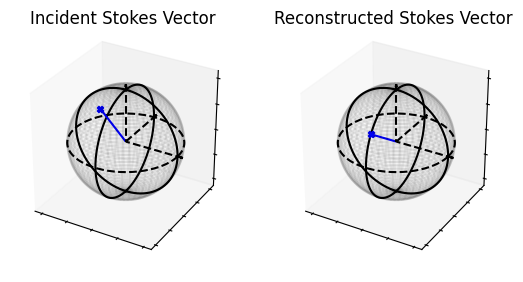

In [49]:
iprime = [2,-1,0,1]
pprime = np.matmul(M,iprime)
rprime = np.matmul(Minverse,pprime)

print(pprime)
print(rprime)
showReconstruction(iprime,rprime)

Although it's a little challenging to fully make sense of this visualization, what we're seeing is the vector being projected down to the horizontal axis. Neat! I pick up where I'm leaving off here in 6pixelarray.ipynb.